<a href="https://colab.research.google.com/github/lenhatquang2512/PointNet_from_scratch/blob/main/pointnet_easy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import sys
import glob
import trimesh
import itertools

from matplotlib import pyplot as plt

In [5]:
pip install trimesh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 669 kB 31.8 MB/s 


In [2]:
## Installation Guide https://www.tensorflow.org/install/pip?hl=en
physical_devices = tf.config.list_physical_devices("GPU")
print("GPUs Available: ", physical_devices)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### DataSetsLoader
Self-defined class for downloading and processing the point cloud datasets. 

#### PointNetFactory
Self-defined class for creating the PointNet model. 

 ### DataSetsLoader

In [43]:
class DataSetsLoader:
    def __init__(self, num_points=2048, num_class=10, use_internet=True):
        self.num_points = num_points
        self.num_class = num_class
        self.data_dir = "./datasets/ModelNet10.zip"
        self.use_internet = use_internet
        self.load_datasets()

    def load_datasets(self):
        if self.use_internet:
            # 3D Vision Dataset: 128 each: http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
            # Latest Datasets - 98 each: http://modelnet.cs.princeton.edu/ModelNet10.zip
            self.data_dir = tf.keras.utils.get_file(
                "modelnet.zip",
                "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
                extract=True,
            )
        else:
            folder = os.getcwd()
            path = os.path.join(folder, "datasets/ModelNet10.zip")
            self.data_dir = tf.keras.utils.get_file(fname="modelnet.zip", origin=path, extract=True)
        self.data_dir = os.path.join(os.path.dirname(self.data_dir), "ModelNet10")

    def show_sample_data(self):
        mesh = trimesh.load(os.path.join(self.data_dir, "sofa/train/sofa_0001.off"))
        mesh.show()

        points = mesh.sample(self.num_points)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.scatter(points[:, 0], points[:, 1], points[:, 2])
        ax.set_axis_off()
        plt.show()

    def transform_to_tensorflow_dataset(self, num_points=2048):
        train_points = []
        train_labels = []
        test_points = []
        test_labels = []
        class_map = {}
        folders = glob.glob(os.path.join(self.data_dir, "[!README]*"))
        # Check if the system is Windows or not
        is_windows = sys.platform.startswith('win')

        for i, folder in enumerate(folders):
            print("processing class: {}".format(os.path.basename(folder)))

            # For Windows OS, the path delimiter is "\\". For Unix OS, the path delimiter is "/"
            if is_windows:
                class_map[i] = folder.split("\\")[-1]
            else:
                class_map[i] = folder.split("/")[-1]
            # gather all files
            train_files = glob.glob(os.path.join(folder, "train/*"))
            test_files = glob.glob(os.path.join(folder, "test/*"))

            for f in train_files:
                train_points.append(trimesh.load(f).sample(num_points))
                train_labels.append(i)

            for f in test_files:
                test_points.append(trimesh.load(f).sample(num_points))
                test_labels.append(i)
        return (
            np.array(train_points),
            np.array(test_points),
            np.array(train_labels),
            np.array(test_labels),
            class_map,
        )

### Orthogonal Regularizer

In [44]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
        self.units = 32 #default unit

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self):
        config = super(OrthogonalRegularizer, self).get_config()
        config.update({"units": self.units})
        return config

### PointnetFactory

In [54]:
class PointNetFactory:
    def __init__(self):
        self.model = []

    def conv_bn(self, x, filters):
        x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
        x = layers.BatchNormalization(momentum=0.0)(x)
        return layers.Activation("relu")(x)

    def dense_bn(self, x, filters):
        x = layers.Dense(filters)(x)
        x = layers.BatchNormalization(momentum=0.0)(x)
        return layers.Activation("relu")(x)

    def tnet(self, inputs, num_features):
        # Initalise bias as the indentity matrix
        bias = keras.initializers.Constant(np.eye(num_features).flatten())
        reg = OrthogonalRegularizer(num_features)

        x = self.conv_bn(inputs, 32)
        x = self.conv_bn(x, 64)
        x = self.conv_bn(x, 512)
        x = layers.GlobalMaxPooling1D()(x)
        x = self.dense_bn(x, 256)
        x = self.dense_bn(x, 128)
        x = layers.Dense(
            num_features * num_features,
            kernel_initializer="zeros",
            bias_initializer=bias,
            activity_regularizer=reg,
        )(x)
        feat_T = layers.Reshape((num_features, num_features))(x)
        # Apply affine transformation to input features
        return layers.Dot(axes=(2, 1))([inputs, feat_T])

    def create_model(self, num_points, num_point_axis, num_classes):
        inputs = keras.Input(shape=(num_points, num_point_axis))
        x = self.tnet(inputs, num_point_axis)
        x = self.conv_bn(x, 64)
        x = self.conv_bn(x, 64)
        x = self.tnet(x, 64)
        x = self.conv_bn(x, 64)
        x = self.conv_bn(x, 128)
        x = self.conv_bn(x, 1024)
        x = layers.GlobalMaxPooling1D()(x)
        x = self.dense_bn(x, 512)
        x = layers.Dropout(0.3)(x)
        x = self.dense_bn(x, 256)
        x = layers.Dropout(0.3)(x)

        outputs = layers.Dense(num_classes, activation="softmax")(x)
        model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
        self.model = model
        return model


### Definition of the Global Variables
* NUM_POINTS: The sampling rate for each point cloud in the dataset
* NUM_CLASSES: The number of total classes in the dataset. ex. ModelNet10 has 10 classes.
* NUM_POINT_AXIS: In each point cloud, we only have x,y,z, so there are 3 axis. If we add RGB into the point cloud, then we have x,y,z,r,g,b, which is 6 axis
* BATCH_SIZE: The number of data in each training batch.

In [10]:
# Global variables
NUM_POINTS = 2048
NUM_CLASSES = 10
NUM_POINT_AXIS = 3
BATCH_SIZE = 32

# Use hardware accelerator for training
physical_devices = tf.config.experimental.list_physical_devices("GPU")
print("GPUs Available: ", physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [48]:
# Load Datasets
datasets_loader = DataSetsLoader(num_points = NUM_POINTS,
                                 num_class= NUM_CLASSES,
    use_internet=False)
train_points, test_points, train_labels, test_labels, CLASS_MAP = datasets_loader.transform_to_tensorflow_dataset()

processing class: dresser
processing class: desk
processing class: chair
processing class: night_stand
processing class: bed
processing class: bathtub
processing class: toilet
processing class: table
processing class: sofa
processing class: monitor


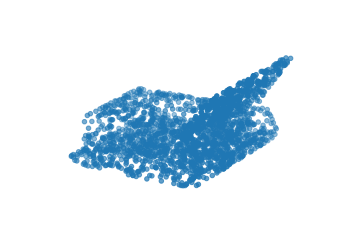

In [49]:
datasets_loader.show_sample_data()

In [12]:
ls

check-gpu-device.ipynb  point-net-classification.ipynb  predict_modelnet.ipynb
drive/                  PointNetFactory.py              sample_data/


In [51]:
# Shuffle and Augment Datasets
def augment(points, label):
        # jitter points
        points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
        # shuffle points
        points = tf.random.shuffle(points)
        return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [55]:
point_net_factory = PointNetFactory()

In [56]:
# Build the PointNet model
model = point_net_factory.create_model(NUM_POINTS, NUM_POINT_AXIS, NUM_CLASSES)
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2048, 3)]    0           []                               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 2048, 32)     128         ['input_4[0][0]']                
                                                                                                  
 batch_normalization_51 (BatchN  (None, 2048, 32)    128         ['conv1d_33[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_51 (Activation)     (None, 2048, 32)     0           ['batch_normalization_51[0

In [57]:
# Train Model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 32s 217ms/step - loss: 4.6727 - sparse_categorical_accuracy: 0.2979 - val_loss: 6.5674 - val_sparse_categorical_accuracy: 0.1344
Epoch 2/20
125/125 [==============================] - 27s 215ms/step - loss: 4.0073 - sparse_categorical_accuracy: 0.4092 - val_loss: 1096057937199104.0000 - val_sparse_categorical_accuracy: 0.3987
Epoch 3/20
125/125 [==============================] - 27s 217ms/step - loss: 3.8050 - sparse_categorical_accuracy: 0.4891 - val_loss: 8.0668 - val_sparse_categorical_accuracy: 0.2401
Epoch 4/20
125/125 [==============================] - 28s 222ms/step - loss: 3.5650 - sparse_categorical_accuracy: 0.5733 - val_loss: 87436377276284928.0000 - val_sparse_categorical_accuracy: 0.5077
Epoch 5/20
125/125 [==============================] - 28s 220ms/step - loss: 3.3633 - sparse_categorical_accuracy: 0.6314 - val_loss: 15474422185984.0000 - val_sparse_categorical_accuracy: 0.6696
Epoch 6/20
125/125 [=====================

In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
# Save Model
model.save_weights("./model.h5")

# Load Model
new_model = point_net_factory.create_model(NUM_POINTS, NUM_POINT_AXIS, NUM_CLASSES)
new_model.load_weights("./model.h5")

In [61]:
# Save Model
model.save_weights("./model2.h5")

# Load Model
new_model = point_net_factory.create_model(NUM_POINTS, NUM_POINT_AXIS, NUM_CLASSES)
new_model.load_weights("./model2.h5")

In [60]:
import shutil
shutil.copy('/content/model2.h5','/content/gdrive/MyDrive/Colab Notebooks')

'/content/gdrive/MyDrive/Colab Notebooks/model2.h5'

In [20]:
pwd

'/content'

1/1 [==============================] - 0s 179ms/step


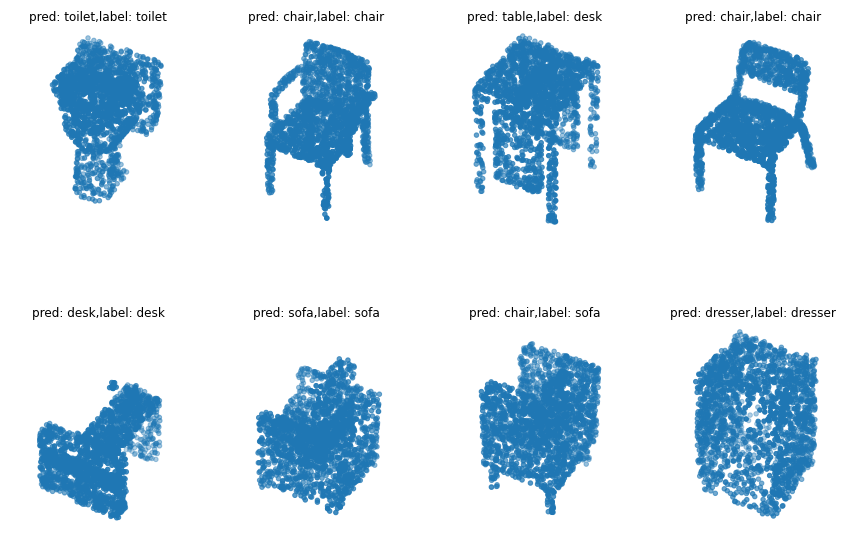

In [67]:
# Predict Results
data = test_dataset.take(1)

points, labels = list(data)[0]
plot_number = 8
points = points[:plot_number, ...]
labels = labels[:plot_number, ...]

# run test data through model
preds = new_model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(plot_number):
    ax = fig.add_subplot(2, plot_number/2, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:},label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.savefig("eecs498_project_predict_result_with" + str(plot_number) + "figs.png")
plt.show()

### Accuracy computing

In [64]:
dataset = test_dataset
total_count = 0
correct_count = 0

for element in dataset.as_numpy_iterator():
    points2 = element[0]
    labels2 = element[1]
    pred2 = new_model.predict(points2)
    pred2 = tf.math.argmax(pred2, -1)
    for index, point in enumerate(points2):
        pred2 = new_model.predict(points2)
        pred2 = tf.math.argmax(pred2, -1)
        total_count += 1
        if labels2[index] == pred2[index]:
            correct_count += 1
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 0s 19ms/step
Accuracy  is 0.816079295154185


In [42]:
dataset = test_dataset
total_count = 0
correct_count = 0

for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = model.predict(points)
    pred = tf.math.argmax(pred, -1)
    for index, point in enumerate(points):
        pred = model.predict(points)
        pred = tf.math.argmax(pred, -1)
        total_count += 1
        if labels[index] == pred[index]:
            correct_count += 1
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 0s 18ms/step
Accuracy  is 0.6299559471365639


 ### Precision matrix
 

In [97]:
from sklearn.metrics import confusion_matrix

all_preds = []
all_labels = []
dataset = test_dataset
for element in dataset.as_numpy_iterator():
    points = element[0]
    labels = element[1]
    pred = model.predict(points)
    pred = tf.math.argmax(pred, -1)
    all_preds += list(pred.numpy())
    all_labels += list(labels)




1/1 [==============================] - 0s 488ms/step


In [101]:
print(preds.shape)
print(labels.shape)
print(CLASS_MAP)
print(len(test_dataset))

print(len(all_preds))
print(len(all_labels))

(32,)
(12,)
{0: 'dresser', 1: 'desk', 2: 'chair', 3: 'night_stand', 4: 'bed', 5: 'bathtub', 6: 'toilet', 7: 'table', 8: 'sofa', 9: 'monitor'}
29
908
908


In [102]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[77,  1,  4,  1,  0,  1,  0,  0,  0,  2],
       [ 7, 46,  7,  2,  2,  0,  0, 12,  9,  1],
       [ 0,  0, 96,  0,  2,  0,  2,  0,  0,  0],
       [32,  0,  1, 53,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 10,  0, 90,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  6, 36,  1,  0,  0,  0],
       [ 1,  0,  9,  0,  0,  1, 89,  0,  0,  0],
       [ 0, 11,  2,  1,  1,  0,  0, 85,  0,  0],
       [ 1,  0,  8,  0,  0,  0,  0,  0, 91,  0],
       [ 0,  0, 20,  0,  0,  0,  1,  0,  1, 78]])

In [106]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("eecs498_project_predict_precision_matrix.png")

Normalized confusion matrix


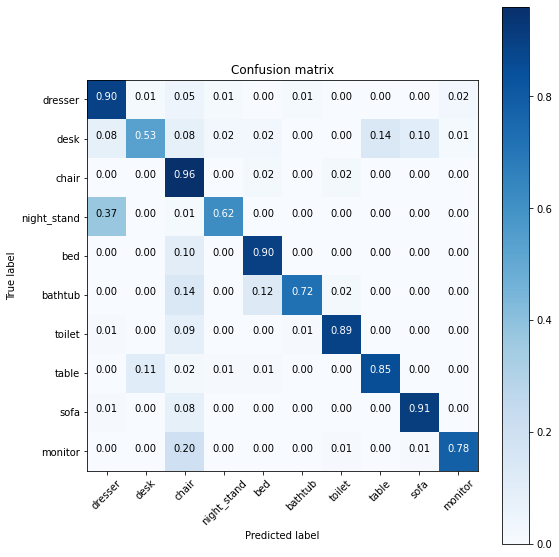

In [107]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(CLASS_MAP.values()), normalize=True)

 ### Without feature transform


In [69]:
class PointNetFactoryNoTransf:
    def __init__(self):
        self.model = []

    def conv_bn(self, x, filters):
        x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
        x = layers.BatchNormalization(momentum=0.0)(x)
        return layers.Activation("relu")(x)

    def dense_bn(self, x, filters):
        x = layers.Dense(filters)(x)
        x = layers.BatchNormalization(momentum=0.0)(x)
        return layers.Activation("relu")(x)

    def tnet(self, inputs, num_features):
        # Initalise bias as the indentity matrix
        bias = keras.initializers.Constant(np.eye(num_features).flatten())
        reg = OrthogonalRegularizer(num_features)

        x = self.conv_bn(inputs, 32)
        x = self.conv_bn(x, 64)
        x = self.conv_bn(x, 512)
        x = layers.GlobalMaxPooling1D()(x)
        x = self.dense_bn(x, 256)
        x = self.dense_bn(x, 128)
        x = layers.Dense(
            num_features * num_features,
            kernel_initializer="zeros",
            bias_initializer=bias,
            activity_regularizer=reg,
        )(x)
        feat_T = layers.Reshape((num_features, num_features))(x)
        # Apply affine transformation to input features
        return layers.Dot(axes=(2, 1))([inputs, feat_T])

    def create_model(self, num_points, num_point_axis, num_classes):
        inputs = keras.Input(shape=(num_points, num_point_axis))
        x = self.tnet(inputs, num_point_axis)
        x = self.conv_bn(x, 64)
        x = self.conv_bn(x, 64)
        # x = self.tnet(x, 64)
        x = self.conv_bn(x, 64)
        x = self.conv_bn(x, 128)
        x = self.conv_bn(x, 1024)
        x = layers.GlobalMaxPooling1D()(x)
        x = self.dense_bn(x, 512)
        x = layers.Dropout(0.3)(x)
        x = self.dense_bn(x, 256)
        x = layers.Dropout(0.3)(x)

        outputs = layers.Dense(num_classes, activation="softmax")(x)
        model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
        self.model = model
        return model

In [70]:
point_net_factory_noFeatTF = PointNetFactoryNoTransf()

In [73]:
# Build the PointNet model
model_noFeatTF = point_net_factory_noFeatTF.create_model(NUM_POINTS, NUM_POINT_AXIS, NUM_CLASSES)
# model_noFeatTF.summary()

In [74]:
# Train Model
model_noFeatTF.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model_noFeatTF.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 23s 162ms/step - loss: 1.9597 - sparse_categorical_accuracy: 0.4082 - val_loss: 499.0821 - val_sparse_categorical_accuracy: 0.5419
Epoch 2/20
125/125 [==============================] - 20s 161ms/step - loss: 1.2785 - sparse_categorical_accuracy: 0.6412 - val_loss: 3171.3884 - val_sparse_categorical_accuracy: 0.6718
Epoch 3/20
125/125 [==============================] - 21s 165ms/step - loss: 0.9857 - sparse_categorical_accuracy: 0.7344 - val_loss: 1005784.5000 - val_sparse_categorical_accuracy: 0.7467
Epoch 4/20
125/125 [==============================] - 21s 165ms/step - loss: 0.8230 - sparse_categorical_accuracy: 0.7785 - val_loss: 23157.6152 - val_sparse_categorical_accuracy: 0.8216
Epoch 5/20
125/125 [==============================] - 21s 167ms/step - loss: 0.6822 - sparse_categorical_accuracy: 0.8151 - val_loss: 1.8500 - val_sparse_categorical_accuracy: 0.7423
Epoch 6/20
125/125 [==============================] - 21s 167ms/step -

In [76]:
# Save Model
model_noFeatTF.save_weights("./model_noFeatTF.h5")

# Load Model
new_model_noFeatTF = point_net_factory_noFeatTF.create_model(NUM_POINTS, NUM_POINT_AXIS, NUM_CLASSES)
new_model_noFeatTF.load_weights("./model_noFeatTF.h5")

shutil.copy('/content/model_noFeatTF.h5','/content/gdrive/MyDrive/Colab Notebooks')

'/content/gdrive/MyDrive/Colab Notebooks/model_noFeatTF.h5'

1/1 [==============================] - 0s 344ms/step


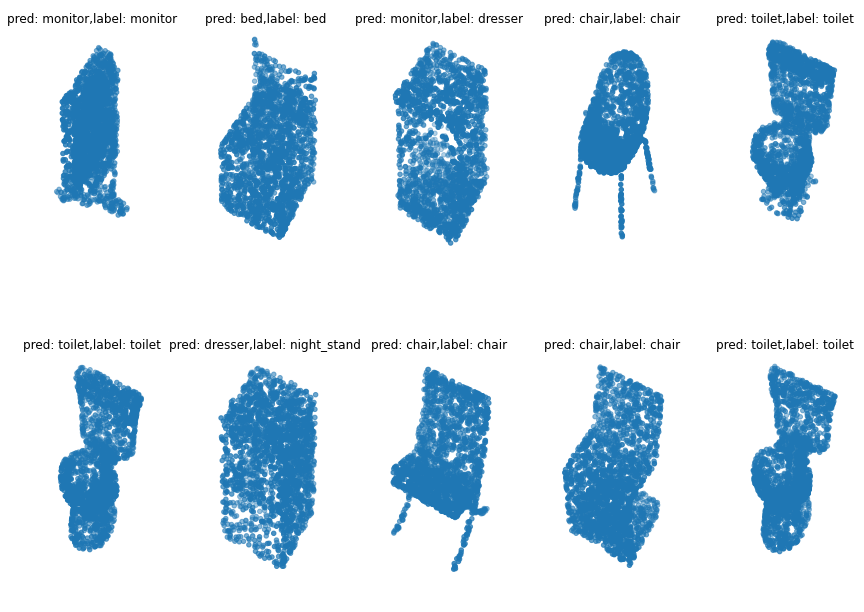

In [77]:
# Predict Results
data = test_dataset.take(1)

points, labels = list(data)[0]
plot_number = 10
points = points[:plot_number, ...]
labels = labels[:plot_number, ...]

# run test data through model
preds = new_model_noFeatTF.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 11))
for i in range(plot_number):
    ax = fig.add_subplot(2, plot_number/2, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:},label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.savefig("eecs498_project_predict_result_NO_FeatTF_with" + str(plot_number) + "figs.png")
plt.show()

In [78]:
dataset = test_dataset
total_count = 0
correct_count = 0

for element in dataset.as_numpy_iterator():
    points3 = element[0]
    labels3 = element[1]
    pred3 = new_model_noFeatTF.predict(points2)
    pred3 = tf.math.argmax(pred2, -1)
    for index, point in enumerate(points3):
        pred3 = new_model.predict(points3)
        pred3 = tf.math.argmax(pred3, -1)
        total_count += 1
        if labels3[index] == pred3[index]:
            correct_count += 1
            
accuracy  = correct_count / total_count
print("Accuracy  is {}".format(accuracy))

1/1 [==============================] - 0s 17ms/step
Accuracy  is 0.816079295154185
